# The Barn

Prepares data for The Barn signature events page

In [1]:
from events import (
    load_event_data, filter_public_events, filter_by_project, prepare, save_files, count_wards
)

Set an output directory

In [2]:
OUT_DIR = '../../../../docs/metrics/events/the-barn/_data/events'

Read in event data and filter by **The Barn**

In [3]:
data = (
  load_event_data()
    .pipe(filter_by_project, '05 - The Barn')
    .pipe(filter_public_events)
  )

Run the processing and save the files

In [4]:
data = data.pipe(prepare).pipe(save_files, OUT_DIR)

Print a list of events which have no ward, or more than one

In [5]:
data[data.pipe(count_wards) != 1][[
    'airtable_id',
    'event_name',
    'start_date',
    'ward_(from_venue)',
]]

,airtable_id,event_name,start_date,ward_(from_venue)
695,351,The Space Digital Interactive Playspace,2023-05-16,NaN
696,1623,The Space Digital Interactive Playspace (schoo...,2023-05-16,NaN


Print a list of events with no audience recorded

In [6]:
data[data.audience_size == 0][[
    'airtable_id', 'event_name', 'start_date', 'audience_size'
]]

,airtable_id,event_name,start_date,audience_size
672,1156,Shazia Mirza - 9pm show,2023-05-11,0.0
719,1162,Christie Watson,2023-05-21,0.0


Plot event types shown

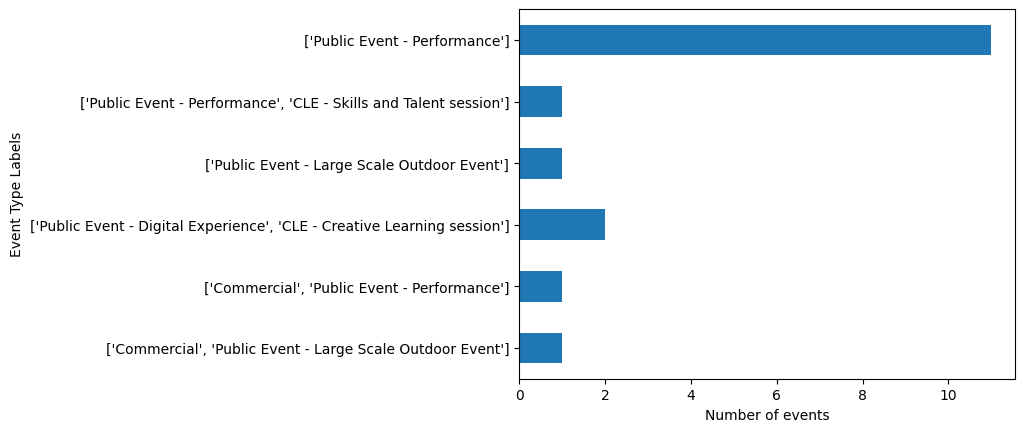

In [7]:
plot = data.groupby('event_type').event_name.count().plot.barh()
plot.xaxis.label.set_text('Number of events')
plot.yaxis.label.set_text('Event Type Labels')